# Section 1: TCAV
Please refer this source https://github.com/tensorflow/tcav on how you can import and run TCAV. The repository consists of an example (https://github.com/tensorflow/tcav/blob/master/Run_TCAV_on_colab.ipynb) of TCAV scores using GoogLeNet model trained on ImageNet dataset. The examples demonstrated the results based the concepts ["dotted","striped","zigzagged"] with target being 'zebra'. 

You are allowed to change the code template in accordance with the example provided. 

In [1]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [2]:
"""
!pip3 install virtualenv
!virtualenv theanoEnv
!source /content/theanoEnv/bin/activate;
!sudo apt-get update -y

!sudo apt-get install python3.7
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1

##THIS COMMAND WILL ASK FOR CHOICE OF OPTION. SELECT 2 AND HIT ENTER.
!sudo update-alternatives --config python3 """



'\n!pip3 install virtualenv\n!virtualenv theanoEnv\n!source /content/theanoEnv/bin/activate;\n!sudo apt-get update -y\n\n!sudo apt-get install python3.7\n!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1\n\n##THIS COMMAND WILL ASK FOR CHOICE OF OPTION. SELECT 2 AND HIT ENTER.\n!sudo update-alternatives --config python3 '

In [3]:
#python --version

In [4]:
"""
!sudo apt install python3-pip
!sudo apt install python3.7-distutils

!pip3 install tensorflow==1.15
!pip install keras==2.2.4"""


'\n!sudo apt install python3-pip\n!sudo apt install python3.7-distutils\n\n!pip3 install tensorflow==1.15\n!pip install keras==2.2.4'

In [5]:

"""%load_ext autoreload
%autoreload 2"""


'%load_ext autoreload\n%autoreload 2'

In [6]:
!git clone https://github.com/pnxenopoulos/cav-keras.git
%cd cav-keras

fatal: destination path 'cav-keras' already exists and is not an empty directory.
/content/cav-keras


In [7]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.datasets import cifar100, cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50

import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

from cav.tcav import *
import tensorflow as tf
np.random.seed(1996)


In [8]:
def extract_airplane_set():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Keep airplanes from CIFAR-10
    interested_class = y_train == [0]
    interested_class_indx = [i for i, x in enumerate(interested_class) if x]
    x_train_class_one = x_train[interested_class_indx]
    other = y_train == [2]
    other_indx = [i for i, x in enumerate(other) if x]
    x_train_class_two = x_train[other_indx]

    x_train = np.append(x_train_class_one, x_train_class_two, axis = 0)
    y_train = [1] * 5000
    y_train = y_train + [0] * 5000

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x_train[0])
    axarr[1].imshow(x_train[7777])
    return x_train, y_train, x_test, y_test

def extract_cloud_set():
    (x_train_concept, y_train_concept), (x_test_concept, y_test_concept) = cifar100.load_data()

    # keep cloud (23) from CIFAR-100
    concept = y_train_concept == [23]
    indices = concept
    indx_to_use = [i for i, x in enumerate(indices) if x]

    x_train_concept = x_train_concept[indx_to_use]
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x_train_concept[83])
    axarr[1].imshow(x_train_concept[5])
    return x_train_concept, y_train_concept
import torch.nn as nn
from keras.layers import Add
#credits for https://github.com/pnxenopoulos/cav-keras/blob/master/docs/examples/cifar_example.ipynb
def load_and_transfer_learn():
    # Load the ResNet50 model without the top layers

    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    #model.add(Activation('sigmoid'))
    model.add(Dense(10, activation='sigmoid'))
   
 

    

    """resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

    # Freeze the pre-trained layers
    for layer in resnet_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = resnet_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(10, activation='softmax')(x)

    # Create the final model
    model = keras.models.Model(inputs=resnet_model.input, outputs=x)"""

    return model


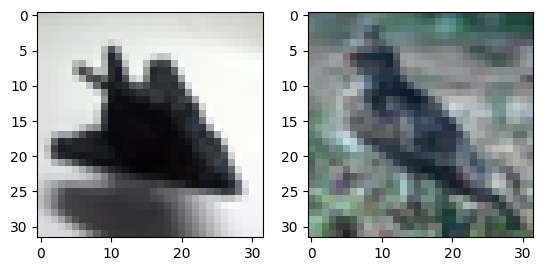

In [9]:
x_train, y_train, x_test, y_test = extract_airplane_set()

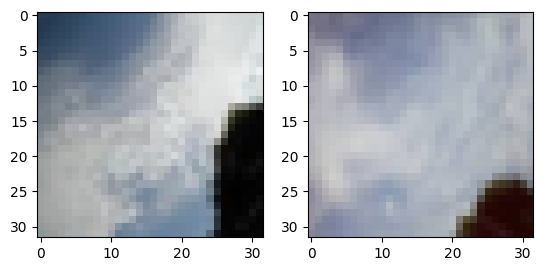

In [10]:
x_train_concept, y_train_concept = extract_cloud_set()

In [11]:
model = load_and_transfer_learn()
batch_size = 32
epochs = 5

optim = keras.optimizers.Adam(lr=0.001)  

from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)

# train the model


model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/5
313/313 [==============================] - 9s 9ms/step - loss: 0.5039 - accuracy: 0.0000e+00
Epoch 2/5
313/313 [==============================] - 2s 5ms/step - loss: 0.2309 - accuracy: 0.4207
Epoch 3/5
313/313 [==============================] - 2s 5ms/step - loss: 0.0997 - accuracy: 0.8176
Epoch 4/5
313/313 [==============================] - 2s 5ms/step - loss: 0.0886 - accuracy: 0.8432
Epoch 5/5
313/313 [==============================] - 2s 5ms/step - loss: 0.0821 - accuracy: 0.8573


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

In [ ]:
import sys

print(sys.getrecursionlimit()) # Prints 1000
sys.setrecursionlimit(20000)
def tcav_scores(model, x_train, y_train, x_train_concept):
    tcav_obj = TCAV()
    tcav_obj.set_model(model)

    tcav_obj.split_model(bottleneck = 1,conv_layer = True )
    tcav_obj.train_cav(x_train_concept)
    print("y_train.shape",y_train.shape)
    
    y_train = y_train.argmax(axis=1)
    
    tcav_obj.calculate_sensitivity(x_train, y_train )

    
    tcav_obj.print_sensitivity()
   
    
tcav_scores(model, x_train, y_train, x_train_concept)

"""
In tcav.py inside the calculate_sensitivty function
        self.model_f.compile(run_eagerly = True)
        model_f_activations = self.model_f.predict(x_train)
        tf.compat.v1.disable_eager_execution()

"""

1000
32/32 [==============================] - 0s 2ms/step
y_train.shape (10000, 10)
313/313 [==============================] - 1s 3ms/step
